# Regressão polinomial

## Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.optimize as opt

## Importação dos dados

In [3]:
data = spio.loadmat('data/ex5data1.mat', squeeze_me=True)
X, y = data['X'], data['y']
X_test, y_test = data['Xtest'], data['ytest']
X_val, y_val = data['Xval'], data['yval']
m = len(y)
m_test = len(y_test)
m_val = len(y_val)

## Adicionando características

In [4]:
def poly_features(X, p):
    X_poly = np.ones((X.shape[0], p + 1))
    for i in range(p):
        X_poly[:, i + 1] = X[:, 1] ** (i + 1)
    return X_poly

def poly_features2(X, p):   
    X_poly = np.zeros((X.shape[0], p))
    for i in range(p):
        X_poly[:, i] = X[:, 0] ** (i + 1)
    return X_poly

X_ones = np.stack([np.ones(m), X], axis=1)
X_test_ones = np.stack([np.ones(m_test), X_test], axis=1)
X_val_ones = np.stack([np.ones(m_val), X_val], axis=1)

X_test_poly = poly_features(X_test_ones, 5)
X_val_poly = poly_features(X_val_ones, 5)
X_poly = poly_features(X_ones, 5)

## Aprendizado

### Normalização das características

In [5]:
def normalize_features(X):
    X_norm = np.ones(X.shape)
    mu = np.mean(X[:,1:], axis=0)
    sigma = np.std(X[:,1:], axis=0)
    X_norm[:,1:] = (X[:,1:] - mu) / sigma
    return X_norm, mu, sigma

X_test_norm, mu, sigma = normalize_features(X_test_poly)
X_val_norm, mu, sigma = normalize_features(X_val_poly)
X_norm, mu, sigma = normalize_features(X_poly)

### Função de custo

A função de custo e gradiente são os mesmos utilizados para a regressão linear regularizada.

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right)^2 + \lambda \sum_{j=1}^n \theta_j^2 $$

In [6]:
def compute_cost(theta, X, y, l):
    return (1 / (2 * m)) * (np.sum((X @ theta - y) ** 2) + l * np.sum(theta[1:] ** 2))

theta = np.ones(X_norm.shape[1])
print('J: ', compute_cost(theta, X_norm, y, 0))

J:  104.83498392623122


### Gradiente

$$ \theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_0^{(i)} $$
$$ \theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right) x_j^{(i)} + \frac{\lambda}{m} \theta_j \qquad j \in \{1, 2, \ldots, n\} $$

In [7]:
def gradient(theta, X, y, L):
    grad = (X.T @ ((X @ theta) - y)) / m
    grad[1:] = grad[1:] + (L / m) * theta[1:]
    return grad

In [8]:
fit_theta = opt.fmin_cg(f=compute_cost, x0=theta, fprime=gradient, args=(X_norm, y, 0), disp=False)
print('J: ', compute_cost(fit_theta, X_norm, y, 0))
print('J_val: ', compute_cost(fit_theta, X_val_norm, y_val, 0))
print('J_test: ', compute_cost(fit_theta, X_test_norm, y_test, 0))

J:  0.20849612419006763
J_val:  25.049949653434513
J_test:  19.64621062585001


[2.86887308e+01 7.54346385e+02 4.61380464e+04 1.66104441e+06
 8.99399404e+07]
[11.21758556 11.5148946  13.87883391  6.59846824 -8.81178924 -7.12337335]


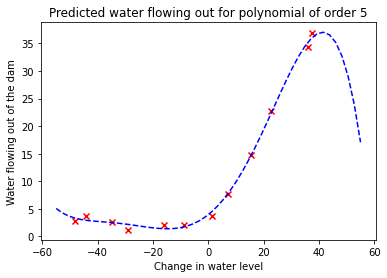

In [9]:
xvalue = np.linspace(-55, 55, 50)
xvalue_ones = np.insert(xvalue.reshape((-1, 1)), 0, 1, axis=1)
xpoly = poly_features(xvalue_ones, 5)
print(sigma)
xpoly[:, 1:] = (xpoly[:, 1:] - mu) / sigma
print(fit_theta)
plt.scatter(X, y, color='red', marker='x')
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
plt.plot(xvalue, (xpoly @ fit_theta), "b--")
plt.title("Predicted water flowing out for polynomial of order 5")
plt.show()

Conforme pode ser observado no gráfico, a curva azul indicando o modelo treinamento se ajusta melhor aos dados comparado com o modelo da regressão linear regularizada.

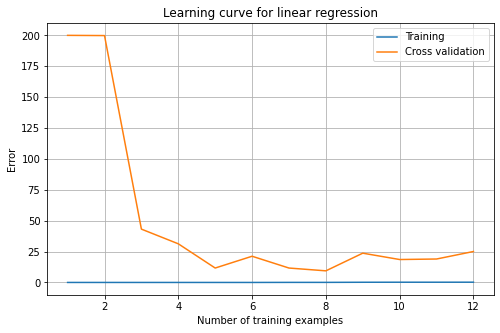

In [10]:
def learning_curve(theta, X, y, X_val, y_val, L):
    m = len(y)
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    for i in range(1, m + 1):
        theta_train = opt.fmin_cg(f=compute_cost, x0=theta, fprime=gradient, args=(X[:i], y[:i], L), disp=False)
        error_train[i - 1] = compute_cost(theta_train, X[:i], y[:i], L)
        error_val[i - 1] = compute_cost(theta_train, X_val, y_val, L)
    return error_train, error_val

error_train, error_val = learning_curve(theta, X_norm, y, X_val_norm, y_val, 0)

x_value = np.arange(1., len(error_train) + 1)
plt.figure(figsize=(8, 5))
plt.plot(x_value, error_train, label="Training")
plt.plot(x_value, error_val, label="Cross validation")
plt.legend(loc="upper right")
plt.xlabel("Number of training examples")
plt.ylabel("Error")
plt.title("Learning curve for linear regression")
plt.grid(True)
plt.show()

Conforme pode ser observado no gráfico, o modelo da regressão linear polinomial apresenta uma quantidade menor de erros do que o modelo da regressão linear regularizada, indicando um modelo mais adequado e menor enviesado do que o anterior.